<a href="https://colab.research.google.com/github/AlbionKransiqi/Capstone/blob/main/Mask_RCNN_PyTorch_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!pip install utils


Cloning into 'vision'...
remote: Enumerating objects: 39258, done.
remote: Counting objects: 100% (4754/4754), done.
remote: Compressing objects: 100% (1325/1325), done.
remote: Total 39258 (delta 3684), reused 4281 (delta 3324), pack-reused 34504
Receiving objects: 100% (39258/39258), 52.13 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (30216/30216), done.


In [ ]:
import utils
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.

# for image augmentations
! pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

     |████████████████████████████████| 117 kB 31.8 MB/s 
     |████████████████████████████████| 948 kB 35.9 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=442ec06900719e1d8312062ff8a9142611c94366ea0f1f8ed372c00e6189d4f9
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/My Drive/capstone_data/train_zip/train/"
test_path= "/content/drive/My Drive/capstone_data/test_zip/test/"

In [ ]:
from glob import glob
import os
files_dir = glob("/content/drive/My Drive/capstone_data/train_zip/train/*")
test_dir = glob("/content/drive/My Drive/capstone_data/test_zip/test/*")

In [ ]:
class FruitImageDataset(torch.utils.data.Dataset):
    
    def __init__(self, files_dir, train_path, width, height, transforms=None):
        self.files_dir = files_dir
        self.train_path = train_path
        self.width = width
        self.height = height
        self.transforms = transforms  # If transformation is required, when transforms is not None
        
        self.classes_ = [_, 'apple', 'orange', 'banana']  # Defining classes, a blank class is given for the background
        
        self.images = [image for image in sorted(files_dir)
                        if image[-4:]=='.jpg']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.train_path, img_name)
        
        # Reading the image
        img = cv2.imread(img_path)
        
        # Defining width and height
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Converting image to RGB channel and normalizing the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = cv2.resize(img, (self.width, self.height), cv2.INTER_AREA)
        img /= 255.0
        
        annot_name = img_name[:-4] + '.xml'
        annot_path = os.path.join(self.train_path, annot_name)
        
        # Boxes to store the coordinate points of the bboxes
        boxes, labels = [], []
        
        tree = et.parse(annot_path)
        root = tree.getroot()
        
        # Box coordinates are extracted from the XML files for the given image size
        for member in root.findall('object'):
            labels.append(self.classes_.index(member.find('name').text))
            
            xmin = float(member.find('bndbox').find('xmin').text)
            xmax = float(member.find('bndbox').find('xmax').text)
            ymin = float(member.find('bndbox').find('ymin').text)
            ymax = float(member.find('bndbox').find('ymax').text)
            
            x_min = (xmin/wt)*self.width
            x_max = (xmax/wt)*self.width
            y_min = (ymin/ht)*self.height
            y_max = (ymax/ht)*self.height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
        # Conversion to Tensors   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # Calculating area of the boxes
        
        iscrowd = torch.zeros((boxes.shape[0], ), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        target = {'boxes': boxes, 'area': area, 'labels': labels, 
                'iscrowd': iscrowd, 'image_id':image_id}
        
        if self.transforms:
            sample = self.transforms(image = img,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img, target

In [ ]:
# Observing the dataset without any transformation
dataset = FruitImageDataset(files_dir, train_path, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  240 



In [ ]:
# getting the image and target for a test index.  Feel free to change the index.
import cv2
img, target = dataset[78]
print(img.shape, '\n',target)

(224, 224, 3) 
 {'boxes': tensor([[ 22.4000,  36.4903, 163.1000,  68.6452],
        [ 24.8500,  39.3806, 163.4500,  94.2968],
        [ 28.0000,  52.3871, 166.9500, 127.8968],
        [ 71.0500,  59.6129, 193.9000, 157.5226]]), 'area': tensor([ 4524.1865,  7611.3750, 10492.0693, 12028.2041]), 'labels': tensor([3, 3, 3, 3]), 'iscrowd': tensor([0, 0, 0, 0]), 'image_id': tensor([78])}


In [ ]:
def plot_img_bbox(img, target):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

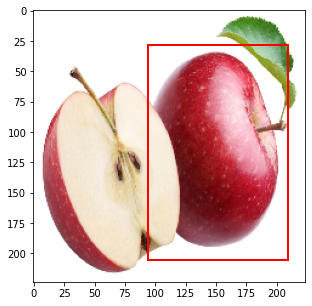

In [ ]:
img, target = dataset[25]
plot_img_bbox(img, target)

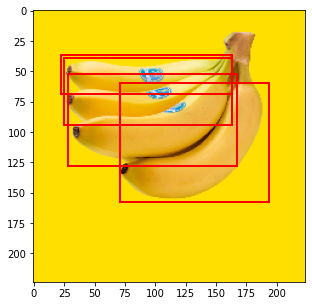

In [ ]:
img, target = dataset[78]
plot_img_bbox(img, target)

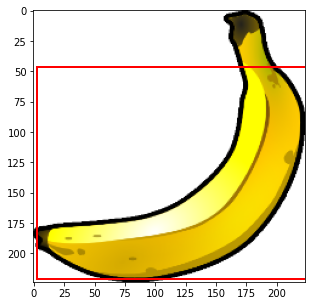

In [ ]:
img, target = dataset[120]
plot_img_bbox(img, target)

In [ ]:
from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [ ]:
def get_model(num_classes, modelName):
    
    # Loading the pre-trained model
    if modelName == 'fastcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model
    
    elif modelName == 'maskcnn':
        model = maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

In [ ]:
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            ToTensorV2(p=0.1),     # ToTensorV2 converts image to PyTorch tensor without dividing by 255
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
def default_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum(x.numel() for x in batch)
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return default_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, collections.abc.Mapping):
        return {key: default_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(default_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, collections.abc.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [default_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))

In [ ]:
# use our dataset and defined transformations
dataset_train = FruitImageDataset(files_dir, train_path, 480, 480, transforms= get_transform(train=True))
dataset_test = FruitImageDataset(test_dir, test_path, 480, 480, transforms= get_transform(train=False))

test_split = 0.2

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# Train test split
tsize = int(len(dataset) * test_split) # Getting the splitting index
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

In [ ]:
# Defining dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=None)
  
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=None)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 4 # Can try by changing to 3 as 1 class is devoted for background
num_epochs = 9

def start_training(modelName, num_epochs, num_classes):
    model = get_model(num_classes, modelName)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.005)
    
    # Learning rate decreases by 10 every 5 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    return model

In [ ]:
fast_rcnn = start_training('fastcnn', num_epochs, num_classes)

In [ ]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)
    
    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# Function to convert a torch tensor to a PIL Image
def tensorToPIL(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [ ]:
# pick one image from the test set
img, target = dataset_test[0]

# put the model in evaluation mode
fast_rcnn.eval()
with torch.no_grad():
    prediction = fast_rcnn([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  100
real #boxes:  2


EXPECTED OUTPUT


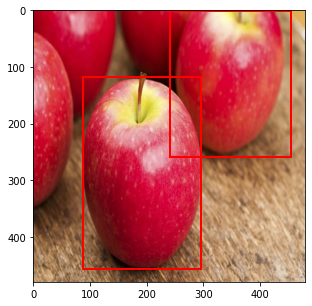

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(tensorToPIL(img), target)

MODEL OUTPUT


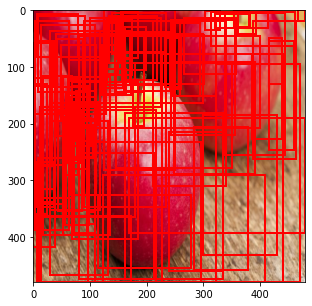

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(tensorToPIL(img), prediction)